In [10]:
# !pip install deap --use-pep517

# **Concrete mix Compressive Strength estimation based on Regression model**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
import math
import copy

from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize
from deap import base, creator, tools, algorithms

import warnings
warnings.filterwarnings('ignore')

In [4]:
file_path = "Concrete_Strength_Data.csv"
concrete_data = pd.read_csv(file_path)
concrete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cement                     1030 non-null   float64
 1   BlastFurnaceSlag           1030 non-null   float64
 2   FlyAshComponent            1030 non-null   float64
 3   WaterComponent             1030 non-null   float64
 4   SuperplasticizerComponent  1030 non-null   float64
 5   CoarseAggregateComponent   1030 non-null   float64
 6   FineAggregateComponent     1030 non-null   float64
 7   AgeInDays                  1030 non-null   int64  
 8   Strength                   1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


#### **Identify Missing Values and Duplicate Rows**

In [5]:
print(f"Number of missing values in each column:")
print(concrete_data.isnull().sum())

n_duplicate_rows = concrete_data.duplicated().sum()
print(f"\nNumber of duplicate rows: {n_duplicate_rows}")

if n_duplicate_rows > 0:
    concrete_data = concrete_data.drop_duplicates()
    print(f"Removed {n_duplicate_rows} duplicate rows from the dataset")

print(concrete_data.describe())

Number of missing values in each column:
Cement                       0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
Strength                     0
dtype: int64

Number of duplicate rows: 25
Removed 25 duplicate rows from the dataset
            Cement  BlastFurnaceSlag  FlyAshComponent  WaterComponent  \
count  1005.000000       1005.000000      1005.000000     1005.000000   
mean    278.631343         72.043483        55.536318      182.075323   
std     104.344261         86.170807        64.207969       21.339334   
min     102.000000          0.000000         0.000000      121.800000   
25%     190.700000          0.000000         0.000000      166.600000   
50%     265.000000         20.000000         0.000000      185.700000   
75%     349.000000        142.500000       118.300000      192.900000   
max     54

In [6]:
y_initial = concrete_data['Strength']
y_initial = np.array(y_initial)
concrete_data = concrete_data.drop(columns=['Strength'])

x_initial = concrete_data.copy()
concrete_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1005 entries, 0 to 1029
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cement                     1005 non-null   float64
 1   BlastFurnaceSlag           1005 non-null   float64
 2   FlyAshComponent            1005 non-null   float64
 3   WaterComponent             1005 non-null   float64
 4   SuperplasticizerComponent  1005 non-null   float64
 5   CoarseAggregateComponent   1005 non-null   float64
 6   FineAggregateComponent     1005 non-null   float64
 7   AgeInDays                  1005 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 70.7 KB


In [7]:
print(concrete_data.describe())

            Cement  BlastFurnaceSlag  FlyAshComponent  WaterComponent  \
count  1005.000000       1005.000000      1005.000000     1005.000000   
mean    278.631343         72.043483        55.536318      182.075323   
std     104.344261         86.170807        64.207969       21.339334   
min     102.000000          0.000000         0.000000      121.800000   
25%     190.700000          0.000000         0.000000      166.600000   
50%     265.000000         20.000000         0.000000      185.700000   
75%     349.000000        142.500000       118.300000      192.900000   
max     540.000000        359.400000       200.100000      247.000000   

       SuperplasticizerComponent  CoarseAggregateComponent  \
count                1005.000000               1005.000000   
mean                    6.033234                974.376816   
std                     5.919967                 77.579667   
min                     0.000000                801.000000   
25%                     0.000000

#### **Feature Scaling**

In [8]:
scaler = StandardScaler()
x_initial_scaled = scaler.fit_transform(x_initial)
x_initial_scaled_dataframe = pd.DataFrame(x_initial_scaled, 
                                          columns = concrete_data.columns)
# y_initial = y_initial.reshape(-1, 1)
# y_initial_scaled = scaler.fit_transform(y_initial)
print(x_initial_scaled_dataframe.describe())

             Cement  BlastFurnaceSlag  FlyAshComponent  WaterComponent  \
count  1.005000e+03      1.005000e+03     1.005000e+03    1.005000e+03   
mean  -2.121023e-16      1.131212e-16     5.656062e-17   -8.201289e-16   
std    1.000498e+00      1.000498e+00     1.000498e+00    1.000498e+00   
min   -1.693618e+00     -8.364707e-01    -8.653750e-01   -2.826018e+00   
25%   -8.431237e-01     -8.364707e-01    -8.653750e-01   -7.255629e-01   
50%   -1.307032e-01     -6.042579e-01    -8.653750e-01    1.699435e-01   
75%    6.747251e-01      8.180450e-01     9.779928e-01    5.075166e-01   
max    2.506116e+00      3.336392e+00     2.252612e+00    3.044003e+00   

       SuperplasticizerComponent  CoarseAggregateComponent  \
count               1.005000e+03              1.005000e+03   
mean               -8.484092e-17              1.187773e-15   
std                 1.000498e+00              1.000498e+00   
min                -1.019640e+00             -2.235936e+00   
25%                -1.0

In [9]:
val_stats = x_initial_scaled_dataframe.describe()
val_min = val_stats.loc['min']
val_max = val_stats.loc['max']
bounds = []
for i in range(0, len(val_min), 1):
    tupple_val = (val_min[i], val_max[i])
    bounds.append(tupple_val)

#### **Multicolliearity**
#### **Correlation Matrix:**
- Correlation matrix visualization where each matrix element represents **pairwise Pearson correlation coefficients between different predictors.**

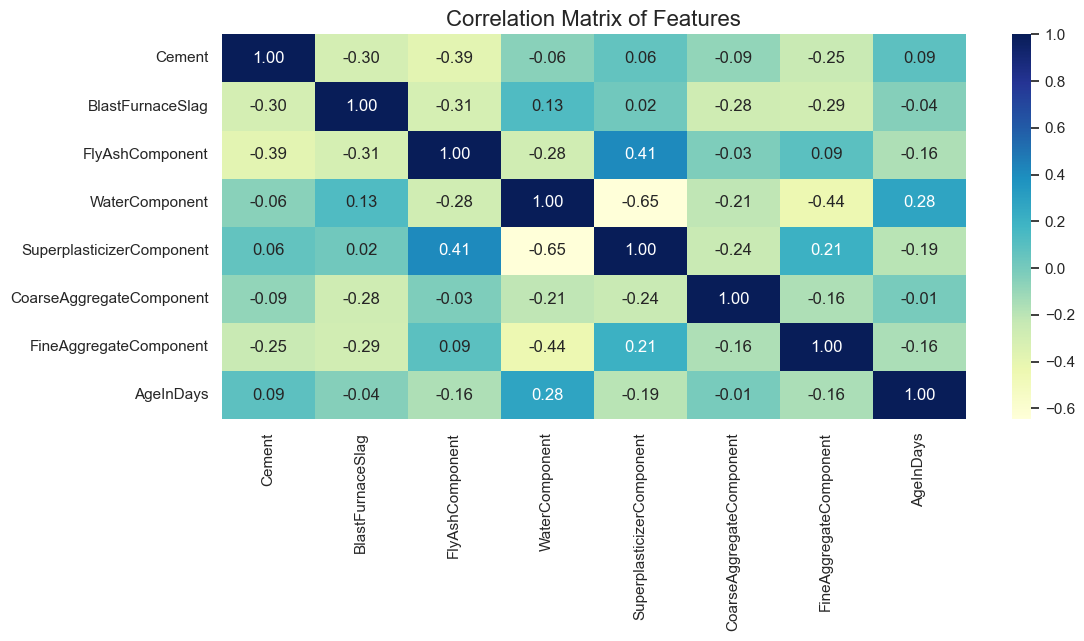

In [10]:
correlation_matrix = x_initial_scaled_dataframe.corr()
plt.figure(figsize = (12, 5))
sns.heatmap(correlation_matrix, 
            annot = True, 
            cmap = 'YlGnBu', 
            fmt = '.2f')
plt.title('Correlation Matrix of Features', 
          fontsize = 16)
plt.show()

#### **Variance Inflation Factor (VIF) for each predictor**

In [11]:
vif_dataframe_x_initial_scaled = pd.DataFrame()
vif_dataframe_x_initial_scaled['Features'] = x_initial_scaled_dataframe.columns
vif_dataframe_x_initial_scaled['VIF Value'] = [variance_inflation_factor(x_initial_scaled_dataframe.values, 
                                                          i) for i in range(0, len(x_initial_scaled_dataframe.columns))]

vif_dataframe_x_initial_scaled

,Features,VIF Value
0,Cement,7.448990
1,BlastFurnaceSlag,7.263275
2,FlyAshComponent,6.084539
3,WaterComponent,6.838492
4,SuperplasticizerComponent,2.867335
5,CoarseAggregateComponent,4.956211
6,FineAggregateComponent,6.972305
7,AgeInDays,1.120113


#### **Splitting dataset for model training and testing**

In [12]:
x_initial_scaled = np.zeros_like(concrete_data)
x_val_list = []
for i in range(0, len(x_initial_scaled_dataframe), 1):
  x_val = x_initial_scaled_dataframe.iloc[i]
  x_val_list.append(x_val)
x_val_array = np.array(x_val_list)
x_initial_scaled = x_val_array

x_train, x_test, y_train, y_test = train_test_split(x_initial_scaled,
                                                    y_initial,
                                                    test_size = 0.2,
                                                    random_state = 42)

#### **Elastic Net Regression Hyperparameter Tuning employing the GridSearchCV**
* $\alpha$ is strength of Regularization / Penality.
* $\rho$ is mix ratio between **Lasso** and **Ridge**

In [13]:
parameter_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}
elastic_net_regression = ElasticNet(max_iter = 10000,
                                   random_state = 42)

grid_search = GridSearchCV(
    estimator = elastic_net_regression,
    param_grid = parameter_grid,
    scoring = 'r2',
    cv = 5,
    n_jobs = -1,
    verbose = 2
)
grid_search.fit(x_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validated R2 Score: {grid_search.best_score_}")

best_elastic_net = grid_search.best_estimator_
y_pred = best_elastic_net.predict(x_test)
r2_score_val = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nTEST DATA: \nR2 score of test data: {r2_score_val}")
print(f"RMSE of test data: {rmse}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.9}
Best Cross-Validated R2 Score: 0.5934689673639161

TEST DATA: 
R2 score of test data: 0.5798842290723278
RMSE of test data: 11.195132468819972


#### **Support Vector Regression model construction and Hyperparameter Tuning employing the GridSearchCV**

In [14]:
param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, .1, 0.5, 1],
    'gamma': ['scale', 'auto', .001, .01, .1, 1]
}

grid_search = GridSearchCV(
    estimator = SVR(),
    param_grid = param_grid,
    scoring = 'r2',
    cv = 5,
    n_jobs = -1,
    verbose = 2
)
grid_search.fit(x_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validated R2 Score: {grid_search.best_score_}")

best_SVR = grid_search.best_estimator_
y_pred = best_SVR.predict(x_test)
r2_score_val = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nTEST DATA: \nR2 score of test data: {r2_score_val}")
print(f"RMSE of test data: {rmse}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'C': 100, 'epsilon': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-Validated R2 Score: 0.8554862125148184

TEST DATA: 
R2 score of test data: 0.8748947553893268
RMSE of test data: 6.10917410873139


#### **Random Forest Regression construction and Hyperparameter Tuning employing GridSearchCV**

In [15]:
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator = RandomForestRegressor(random_state = 42),
    param_grid = param_grid,
    scoring = 'r2',
    verbose = 2,
    n_jobs = -1,
    cv = 5
)

# grid_search.fit(x_train, y_train)

In [16]:
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best Cross-Validated R2 Score: {grid_search.best_score_}")
# best_random_forest = grid_search.best_estimator_

best_random_forest = RandomForestRegressor(bootstrap = False, 
                                           max_depth = 20, 
                                           max_features = 'log2', 
                                           min_samples_leaf = 1, 
                                           min_samples_split = 2,
                                           n_estimators = 500,
                                          random_state = 42)
best_random_forest.fit(x_train, y_train)
y_pred = best_random_forest.predict(x_test)
r2_score_val = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"TEST DATA: \nR\u00B2 score of test data: {r2_score_val}")
print(f"RMSE of test data: {rmse}")

TEST DATA: 
R² score of test data: 0.9199204895096864
RMSE of test data: 4.887710213255583


Feature importance based on Tree Splits:
                    Features  Importance
7                  AgeInDays    0.353821
0                     Cement    0.250090
3             WaterComponent    0.110501
4  SuperplasticizerComponent    0.072498
1           BlastFurnaceSlag    0.062982
6     FineAggregateComponent    0.059697
5   CoarseAggregateComponent    0.045310
2            FlyAshComponent    0.045101


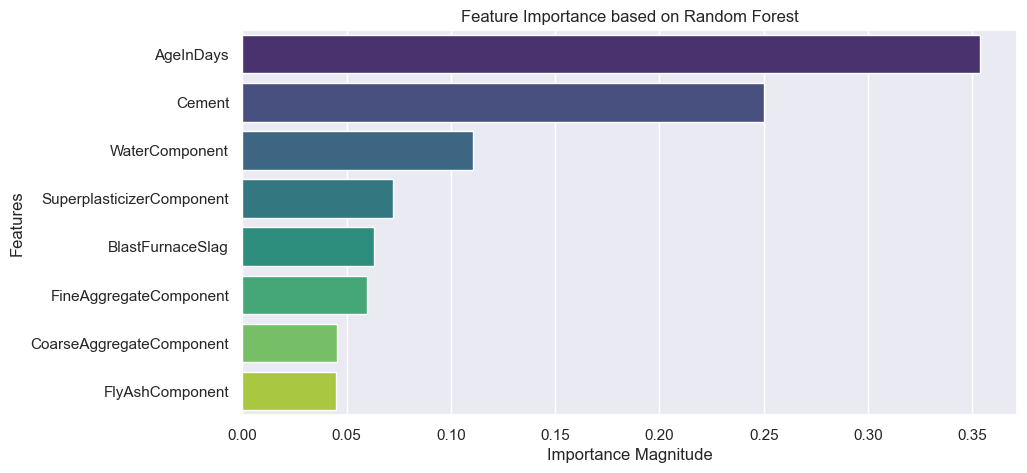

In [17]:
feature_importance = best_random_forest.feature_importances_
feature_importance_df = pd.DataFrame({
    'Features': x_initial_scaled_dataframe.columns,
    'Importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by = 'Importance',
                                                         ascending = False)
print(f"Feature importance based on Tree Splits:")
print(feature_importance_df)

plt.figure(figsize = (10, 5))
sns.barplot(x='Importance', 
            y = 'Features',
            data = feature_importance_df,
            palette = 'viridis')
plt.title('Feature Importance based on Random Forest')
plt.xlabel('Importance Magnitude')
plt.ylabel('Features')
plt.show()

# **Inverse Problem: Concrete Mix for Target Strength and Optimal Cost**
### Genetic Algorithm (GA) as a Search Algorithm

In [18]:
val_stats = concrete_data.describe()
val_min = val_stats.loc['min']
val_max = val_stats.loc['max']

cement_boundries = []
for i in range(0, len(val_min), 1):
    tupple_val = (val_min[i], val_max[i])
    cement_boundries.append(tupple_val)
cement_boundries

[(np.float64(102.0), np.float64(540.0)),
 (np.float64(0.0), np.float64(359.4)),
 (np.float64(0.0), np.float64(200.1)),
 (np.float64(121.8), np.float64(247.0)),
 (np.float64(0.0), np.float64(32.2)),
 (np.float64(801.0), np.float64(1145.0)),
 (np.float64(594.0), np.float64(992.6)),
 (np.float64(1.0), np.float64(365.0))]

In [57]:
penalty_input = 500

target_strength = 35
population_size = 25
max_generations = 50
p_crossover = 0.8
p_mutation = 0.2
elite_size = int((5/100) * population_size)

initial_mutation_rate = 0.05
max_mutation_rate = 0.3

local_search_ind = 2
local_search_maxiter = 20

In [58]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', list, fitness = creator.FitnessMin)

In [59]:
def cost_per_kg_function():
    cost_per_kg = {
    'Cement': 0.15,
    'BlastFurnaceSlag': 0.12,
    'FlyAshComponent': 0.06,
    'WaterComponent': 0.0005,
    'SuperplasticizerComponent': 2.50,
    'CoarseAggregateComponent': 0.03,
    'FineAggregateComponent': 0.03,
    'AgeInDays': 0
    }
    return cost_per_kg

In [60]:
def fitness_function(individual):
    
    features = x_initial_scaled_dataframe.columns.tolist()
    
    cost = 0
    cost_per_kg = cost_per_kg_function()
    for i, feature in enumerate(features):
        cost += individual[i] * cost_per_kg[feature]
    total_cost = round(cost, 2)
    
    model = best_random_forest
    individual_array = np.array(individual).reshape(1, -1)
    individual_scaled = scaler.transform(individual_array)
    pred_strength = model.predict(individual_array)[0]
    
    fitness_value = total_cost
    if abs(float(pred_strength) - float(target_strength)) > 0.5:
        fitness_value += penalty_input * abs(pred_strength - target_strength)

    if fitness_value < 0:
        print(f'Cost: {total_cost}')
    return (fitness_value,)

In [61]:
cement_min, cement_max = cement_boundries[0]
blastfurnaceslag_min, blastfurnaceslag_max = cement_boundries[1]
flyash_min, flyash_max = cement_boundries[2]
water_min, water_max = cement_boundries[3]
superplasticizer_min, superplasticizer_max = cement_boundries[4]
coarseaggregate_min, coarseaggregate_max = cement_boundries[5]
fineaggregate_min, fineaggregate_max = cement_boundries[6]
ageindays_min, ageindays_max = cement_boundries[7]

toolbox = base.Toolbox()
toolbox.register("cement", random.uniform, cement_min, cement_max)
toolbox.register("blastfurnaceslag", random.uniform, blastfurnaceslag_min, blastfurnaceslag_max)
toolbox.register("flyash", random.uniform, flyash_min, flyash_max)
toolbox.register("water", random.uniform, water_min, water_max)
toolbox.register("superplasticizer", random.uniform, superplasticizer_min, superplasticizer_max)
toolbox.register("coarseaggregate", random.uniform, coarseaggregate_min, coarseaggregate_max)
toolbox.register("fineaggregate", random.uniform, fineaggregate_min, fineaggregate_max)
toolbox.register("ageindays", random.uniform, ageindays_min, ageindays_max)

def create_individual():
    return [
        toolbox.cement(),
        toolbox.blastfurnaceslag(),
        toolbox.flyash(),
        toolbox.water(),
        toolbox.superplasticizer(),
        toolbox.coarseaggregate(),
        toolbox.fineaggregate(),
        toolbox.ageindays()
    ]


In [62]:
def mutate_individual(individual, mutation_rate):
    indpb = mutation_rate
    if random.random()  < indpb:
        individual[0] = random.uniform(cement_min, cement_max)
    if random.random()  < indpb:
        individual[1] = random.uniform(blastfurnaceslag_min, blastfurnaceslag_max)
    if random.random()  < indpb:
        individual[2] = random.uniform(flyash_min, flyash_max)
    if random.random()  < indpb:
        individual[3] = random.uniform(water_min, water_max)
    if random.random()  < indpb:
        individual[4] = random.uniform(superplasticizer_min, superplasticizer_max)
    if random.random()  < indpb:
        individual[5] = random.uniform(coarseaggregate_min, coarseaggregate_max)
    if random.random()  < indpb:
        individual[6] = random.uniform(fineaggregate_min, fineaggregate_max)
    if random.random()  < indpb:
        individual[7] = random.uniform(ageindays_min, ageindays_max)

    return (individual, )

In [63]:
toolbox.register('individual', tools.initIterate, creator.Individual, create_individual)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('evaluate', fitness_function)
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', mutate_individual)
toolbox.register('select', tools.selTournament, tournsize = 3)

In [64]:
def local_search(individual):
    def objective_function(x):
        return fitness_function(x)[0]

    x0 = individual

    res = minimize(objective_function,
                  x0,
                  method='L-BFGS-B',
                  bounds=cement_boundries,
                  options={
                      'ftol': 1e-4,
                      'maxiter': local_search_maxiter,
                      'disp': False
                  })
    if res.fun < fitness_function(x0)[0]:
        return res.x.tolist()
    else:
        return individual

### **Visualization**

In [65]:
def run_memetic_ga():
    
    random.seed(42)
    
    population = toolbox.population(n = population_size)

    fitness = map(toolbox.evaluate, population)
    for ind, fit in zip(population, fitness):
        ind.fitness.values = fit

        
    best_individual = tools.selBest(population, 1)[0]
    best_fitness = best_individual.fitness.values[0]

    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals', 'best_fitness']

    mutation_rate = 0.05
    for gen in range(1, max_generations+1, 1):

        offspring = toolbox.select(population, len(population) - elite_size)
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < p_crossover:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if not mutant.fitness.valid:
                toolbox.mutate(mutant, mutation_rate)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitness = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitness):
            ind.fitness.values = fit

        population += offspring

        population = tools.selBest(population, population_size - elite_size)
        top_individuals = tools.selBest(population, local_search_ind)
        for i in range(local_search_ind):
            # original = top_individuals[i].copy() 
            improved = local_search(top_individuals[i])
            top_individuals[i] = improved
            top_individuals[i].fitness.values = toolbox.evaluate(top_individuals[i])
            if top_individuals[i].fitness.values[0] < best_fitness:
                best_fitness = top_individuals[i].fitness.values[0]
                best_individual = top_individuals[i].copy()

        current_best = tools.selBest(population, 1)[0].fitness.values[0]
        logbook.record(gen = gen, 
                       nevals = len(invalid_ind), 
                       best_fitness = current_best)
        print(f'Generation: {gen}, Best Fitness: {current_best:.2f} ')

    print('--- MEMETIC GA OPTIMIZATION for CONCRETE MIX ---\n')
    features = x_initial_scaled_dataframe.columns.tolist()
    cost = 0
    cost_per_kg = cost_per_kg_function()
    for i, feature in enumerate(features):
        cost += best_individual[i] * cost_per_kg[feature]
    total_cost = round(cost, 2)
    
    model = best_random_forest
    individual_array = np.array(best_individual).reshape(1, -1)
    individual_scaled = scaler.transform(individual_array)
    pred_strength = model.predict(individual_array)[0]

    print(f'The raw material cost of the Concrete Mix with, {pred_strength:.4f}MPa is ${total_cost:.2f}per m\u00B3')

In [66]:
if __name__ == '__main__':
    run_memetic_ga()

Generation: 1, Best Fitness: 9084.23 
Generation: 2, Best Fitness: 9076.69 
Generation: 3, Best Fitness: 9076.69 
Generation: 4, Best Fitness: 9043.00 
Generation: 5, Best Fitness: 9043.00 
Generation: 6, Best Fitness: 9031.79 
Generation: 7, Best Fitness: 9030.09 
Generation: 8, Best Fitness: 9030.09 
Generation: 9, Best Fitness: 9030.07 
Generation: 10, Best Fitness: 9029.90 
Generation: 11, Best Fitness: 9029.90 
Generation: 12, Best Fitness: 9027.34 
Generation: 13, Best Fitness: 9027.34 
Generation: 14, Best Fitness: 9027.34 
Generation: 15, Best Fitness: 9027.34 
Generation: 16, Best Fitness: 9027.34 
Generation: 17, Best Fitness: 9027.34 
Generation: 18, Best Fitness: 9027.34 
Generation: 19, Best Fitness: 9027.34 
Generation: 20, Best Fitness: 9026.60 
Generation: 21, Best Fitness: 9026.60 
Generation: 22, Best Fitness: 9026.60 
Generation: 23, Best Fitness: 9026.02 
Generation: 24, Best Fitness: 9026.02 
Generation: 25, Best Fitness: 9026.02 
Generation: 26, Best Fitness: 9026

In [26]:
# def deap_fitness_list(population):
#     object_to_deap_individual = creator.Individual(population)
#     for ind in object_to_deap_individual:
#         ind.fitness.values = toolbox.evaluate(ind)
#     return object_to_deap_individual

In [27]:
# def local_search(ind):
#     new_ind = ind[:]
    
#     new_ind[0] += 2
#     new_ind[1] += 2
#     new_ind[4] += 2

#     # Ensure the values assigned to the new individuals are within the bounds.
#     new_ind[0] = min(max(new_ind[0], cement_min), cement_max)
#     new_ind[1] = min(max(new_ind[1], blast_furnace_slag_min), blast_furnace_slag_max)
#     new_ind[2] = min(max(new_ind[4], superplasticizer_min), superplasticizer_max)

#     new_ind_fitness = toolbox.evaluate(new_ind)[0]
#     if (new_ind_fitness < ind.fitness.values[0]):
#         ind[:] = new_ind
#         return (ind, )

In [28]:
def main():


    avg_val_list = []
    fitness_val_list = []
    best_fitness_ever = math.inf
    mutation_rate = initial_mutation_rate
    no_improvement_limit = 10
    i = 0
    for gen in range(1, max_generations+1, 1):
    


        population[:] = offspring

        gen_best = min(population,
                       key=lambda ind: ind.fitness.values[0])
        gen_best_fitness = gen_best.fitness.values[0]
        if (gen_best_fitness < best_fitness_ever):
            best_fitness_ever = gen_best_fitness
            no_improvement = 0
            
            fitness_val_list.append(gen_best_fitness)
            if (i%10 == 0):
                avg_val_list.append(fitness_val_list[-1])
                if (len(avg_val_list) == 2 ):
                    val_diff = (avg_val_list[0] - avg_val_list[1])
                    if val_diff <= 0.001:
                        break
                    else:
                        print(f'\nSolution Convergence tolerance (0.001): {val_diff:.2f}\n')
                        avg_val_list = []
                        fitness_val_list = []
        else:
            no_improvement += 1
        i = i + 1    
        if (no_improvement >= no_improvement_limit):
            mutation_rate *= 1.5
            if mutation_rate > max_mutation_rate:
                mutation_rate = max_mutation_rate
            print(f'No improvement in Fitness Value.',
                  f'Mutation rate increased to {mutation_rate:.2f}')
            no_improvement = 0

    print('\n---###--- EVOLUTION COMPLETE ---###---')
    print(f'Best Fitness (Cost + Penalties): {fitness_val_list[-1]:.4f}')

    features = x_initial_scaled_dataframe.columns.tolist()
    cost = 0
    cost_per_kg = cost_per_kg_function()
    for i, feature in enumerate(features):
        cost += best_all_islands[i] * cost_per_kg[feature]
    total_cost = round(cost, 2)
    
    model = best_random_forest
    individual_array = np.array(best_all_islands).reshape(1, -1)
    individual_scaled = scaler.transform(individual_array)
    pred_strength = model.predict(individual_array)[0]

    print(f'The raw material cost of the Concrete Mix with, {pred_strength:.4f}MPa is ${total_cost:.2f}m\u00B3')
    return gen_best_fitness

In [ ]:
if __name__ == '__main__':
    solution = main()

In [ ]:

    # # Apply the LOCAL SEARCH
    # sorted_offspring = sorted(offspring, 
    #                           key=lambda ind: ind.fitness.values[0])
    # top_ind = int(0.2 * len(sorted_offspring))
    # for ind in sorted_offspring[:top_ind]:
    #     toolbox.register('local_search', local_search)
    #     toolbox.local_search(ind)
    #     del toolbox.local_search
        
    
    # return population